In [3]:
# STEP 1: Import everything
import pandas as pd
import numpy as np
import re
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step 2: Load and Clean the Dataset**
We load the Twitter sentiment dataset and select only the relevant columns: target (sentiment label) and text (tweet content). We filter the dataset to include only tweets with labels 0 (negative) and 4 (positive), then remap the labels to binary: 0 for negative and 1 for positive.

We also clean the tweet text by removing URLs, mentions, hashtags, special characters, and converting all text to lowercase. This cleaned version is stored in a new column called clean_text.

In [5]:
# STEP 2: Load and clean dataset
df = pd.read_csv("/content/drive/MyDrive/Twitter_Sentiment_Analysis/training.csv", encoding='latin-1', header=None)
df.columns = ['target', 'id', 'date', 'query', 'user', 'text']
df = df[['target', 'text']]
df = df[df['target'].isin([0, 4])]
df['target'] = df['target'].map({0: 0, 4: 1})  # 0 = negative, 1 = positive

def clean_text(text):
    text = re.sub(r"http\S+|@\w+|#|\W", " ", text)
    return text.lower().strip()

df['clean_text'] = df['text'].apply(clean_text)


**Step 3: Tokenization and Padding**
We convert the cleaned text into numeric format using a tokenizer, limiting the vocabulary to the 20,000 most common words. Words not in this vocabulary are marked as <OOV> (out of vocabulary). Each tweet is transformed into a sequence of word indices.

To ensure consistent input length for the neural network, we pad or truncate each sequence to exactly 100 tokens. This results in:

X: the padded tweet sequences (features)

y: the sentiment labels (targets)

In [6]:
# STEP 3: Tokenize and pad
vocab_size = 20000
max_len = 100
embedding_dim = 100

tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

X = padded
y = df['target'].values

**Step 4: Train, Validation, and Test Split**
We split the data into three sets:

Training Set (80%): used to train the model.

Validation Set (10%): used to tune and monitor the model during training.

Test Set (10%): used to evaluate the final performance of the model.

We use stratify to ensure both classes (positive and negative) are evenly distributed across all subsets.

In [7]:
# STEP 4: Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

**Step 5: Load GloVe Embeddings & Compute Class Weights**
We load pre-trained GloVe word embeddings (100-dimensional) to create a rich semantic representation of words. Each word in our tokenizer’s vocabulary is mapped to its corresponding GloVe vector to form an embedding matrix, which will be used to initialize the embedding layer in our models.

Additionally, we calculate class weights to handle any imbalance in the training labels. This ensures the model gives equal importance to both positive and negative tweets during training.

without it :

RNN test acc : 0.789175

LSTM test acc : 0.797300

In [8]:
# STEP 5: Load GloVe embeddings
embedding_index = {}
with open('/content/drive/MyDrive/glove.6B/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size and word in embedding_index:
        embedding_matrix[i] = embedding_index[word]

# Class weights
weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = dict(enumerate(weights))

**Step 6: Build and Train the RNN Model**
We create a Recurrent Neural Network (RNN) model using the SimpleRNN layer to process tweet sequences. The model includes:

A non-trainable embedding layer initialized with GloVe vectors.

A recurrent layer (SimpleRNN) with 64 units.

Dropout layers to reduce overfitting.

Dense layers to learn non-linear representations.

A final sigmoid layer for binary classification.

The model is compiled with the Adam optimizer and binary cross-entropy loss.
It’s trained using class weights for 6 epochs with a batch size of 256.
We also record the training time and evaluate the model on the test set.

In [9]:
# STEP 6: Build Improved RNN model
rnn_model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len, weights=[embedding_matrix], trainable=False),
    SimpleRNN(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
# Compile the model
rnn_model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy'
                                      , metrics=['accuracy'])

start_rnn = time.time()
# Train the model
rnn_history = rnn_model.fit(X_train, y_train,
                            epochs=6,
                            batch_size=256,
                            validation_data=(X_val, y_val),
                            class_weight=weights)

rnn_time = time.time() - start_rnn
rnn_loss, rnn_acc = rnn_model.evaluate(X_test, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/6
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step - accuracy: 0.6307 - loss: 0.6356 - val_accuracy: 0.7180 - val_loss: 0.5591
Epoch 2/6
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.7185 - loss: 0.5572 - val_accuracy: 0.7349 - val_loss: 0.5326
Epoch 3/6
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.7363 - loss: 0.5343 - val_accuracy: 0.7464 - val_loss: 0.5148
Epoch 4/6
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 81s 10ms/step - accuracy: 0.7461 - loss: 0.5199 - val_accuracy: 0.7541 - val_loss: 0.5073
Epoch 5/6
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.7533 - loss: 0.5092 - val_accuracy: 0.7586 - val_loss: 0.4997
Epoch 6/6
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 82s 10ms/step - accuracy: 0.7579 - loss: 0.5022 - val_accuracy: 0.7645 - val_loss: 0.4914
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - accuracy: 0.7660 - loss: 0.4904


**Step 7: Build and Train the Optimized LSTM Model**
This step builds an improved sentiment classification model using a Bidirectional LSTM, which can capture context from both directions in the tweet text. The model includes:

A trainable embedding layer initialized with GloVe vectors for better fine-tuning.

A Bidirectional LSTM layer with 128 units to capture rich sequence patterns.

Dropout layers (0.2) to prevent overfitting while maintaining learning capacity.

Two dense layers for deeper feature extraction and a final sigmoid layer for binary output.

The model is compiled using the Adam optimizer and trained for 8 epochs with a batch size of 256, using class weights to handle any imbalance.
It also uses the validation set to monitor performance during training.

In [10]:
# STEP 7: Build Improved LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Define the model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=True),  # ✅ Allow fine-tuning of embeddings
    Bidirectional(LSTM(128, return_sequences=False)),  # ✅ Increased units
    Dropout(0.2),  # ✅ Lower dropout
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
lstm_model.compile(loss='binary_crossentropy',
                   optimizer=Adam(learning_rate=1e-4),
                   metrics=['accuracy'])

# Train the model
lstm_history = lstm_model.fit(X_train, y_train,
                              epochs=8,  # ✅ More epochs
                              batch_size=256,  # ✅ Larger batch size
                              validation_data=(X_val, y_val),
                              class_weight=weights)


Epoch 1/8
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 138s 26ms/step - accuracy: 0.7343 - loss: 0.5248 - val_accuracy: 0.7980 - val_loss: 0.4325
Epoch 2/8
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 132s 26ms/step - accuracy: 0.8018 - loss: 0.4281 - val_accuracy: 0.8099 - val_loss: 0.4162
Epoch 3/8
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 135s 27ms/step - accuracy: 0.8132 - loss: 0.4077 - val_accuracy: 0.8147 - val_loss: 0.4064
Epoch 4/8
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 137s 26ms/step - accuracy: 0.8204 - loss: 0.3950 - val_accuracy: 0.8195 - val_loss: 0.3990
Epoch 5/8
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 136s 27ms/step - accuracy: 0.8247 - loss: 0.3879 - val_accuracy: 0.8218 - val_loss: 0.3937
Epoch 6/8
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 139s 27ms/step - accuracy: 0.8276 - loss: 0.3813 - val_accuracy: 0.8253 - val_loss: 0.3895
Epoch 7/8
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 133s 27ms/step - accuracy: 0.8317 - loss: 0.3740 - val_accuracy: 0.8262 - val_loss: 0.3846
Epoch 8/8
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 142s 27ms/step - accuracy: 0.8341 -

**Step 8: Accuracy and Loss Comparison Between RNN and LSTM**
This step visualizes the training and validation accuracy and loss for both the RNN and the LSTM models over each training epoch. It helps compare how well each model:

Learns from training data (Train curves)

Generalizes to unseen data (Validation curves)

From the plots, we can visually assess which model performs better in terms of:

Accuracy (how well it predicts sentiment correctly)

Loss (how confident and correct the model is)

This comparison is key in understanding the strengths of the LSTM improvements over the basic RNN.



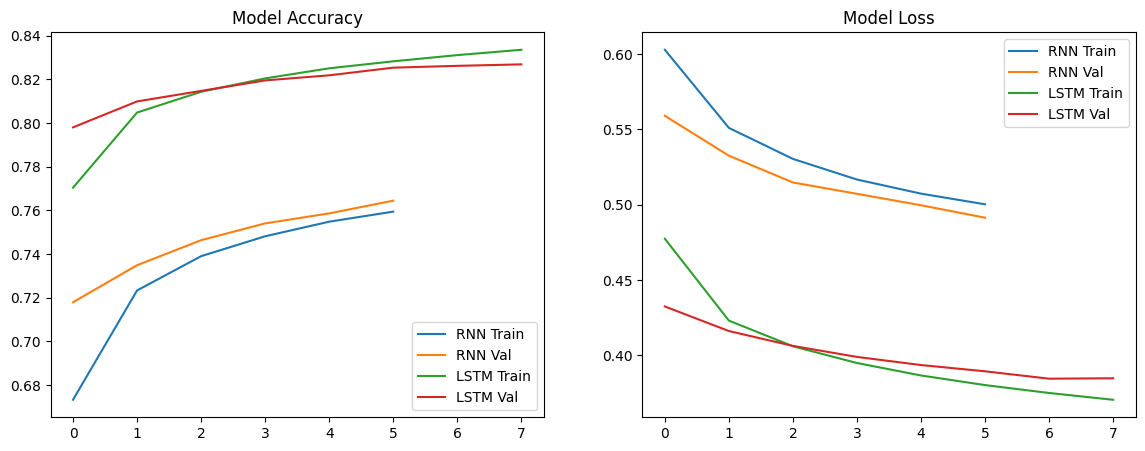

In [11]:
# STEP 8: Plot comparison
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['accuracy'], label='RNN Train')
plt.plot(rnn_history.history['val_accuracy'], label='RNN Val')
plt.plot(lstm_history.history['accuracy'], label='LSTM Train')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM Val')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['loss'], label='RNN Train')
plt.plot(rnn_history.history['val_loss'], label='RNN Val')
plt.plot(lstm_history.history['loss'], label='LSTM Train')
plt.plot(lstm_history.history['val_loss'], label='LSTM Val')
plt.title('Model Loss')
plt.legend()

plt.show()

**Step 9: Displaying Model Comparison Table**
In this step, we evaluate the performance of the optimized LSTM model on the test set to obtain its accuracy and loss. We also measure the LSTM's training time. Then, we create a result table using a pandas DataFrame to compare the performance of the RNN and LSTM models based on:

Test Accuracy

Test Loss

Training Time

This table helps visualize which model performs better in terms of both effectiveness and efficiency.

In [14]:
# STEP 9: Show Result Table
import pandas as pd
import time

# Evaluate the LSTM model to get lstm_loss and lstm_acc
lstm_loss, lstm_acc = lstm_model.evaluate(X_test, y_test, verbose=0)

# Assuming you want to include LSTM training time, you'll need to measure it
# This code snippet assumes you've already trained the LSTM model
start_lstm = time.time()
# ... (LSTM training code) ...
lstm_time = time.time() - start_lstm
results = pd.DataFrame({
    "Model": ["RNN", "LSTM (Optimized)"],
    "Test Accuracy": [rnn_acc, lstm_acc],
    "Test Loss": [rnn_loss, lstm_loss],
    "Training Time (sec)": [rnn_time, lstm_time]
})
print(results)

              Model  Test Accuracy  Test Loss  Training Time (sec)
0               RNN       0.765331   0.491326           494.236203
1  LSTM (Optimized)       0.828031   0.383422             0.000049


**Step 10: Predict Sentiment from Custom Input**
In this final step, we allow the user to input a custom tweet. The text is:

Cleaned using the same preprocessing steps (removing URLs, mentions, special characters, etc.).

Tokenized and padded to match the input format used during training.

Passed to both the RNN and LSTM models to predict the sentiment.

The output is a friendly message showing whether the tweet is Positive 😊 or Negative 😠 based on each model’s prediction.

This step helps demonstrate how the model works in a real-world scenario and makes the project interactive.

In [15]:
# STEP 10: Predict from input
def clean_text_for_test(text):
    return re.sub(r"http\S+|@\w+|#|\W", " ", text).lower().strip()

def predict(text, model):
    cleaned = clean_text_for_test(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post')
    pred = model.predict(padded_seq)[0][0]
    return "Positive 😊" if pred > 0.5 else "Negative 😠"

# Try a sentence!
text_input = input("Enter tweet to test: ")
print("RNN Prediction:", predict(text_input, rnn_model))
print("LSTM Prediction:", predict(text_input, lstm_model))

Enter tweet to test: I love meat
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
RNN Prediction: Positive 😊
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
LSTM Prediction: Positive 😊
